In [1]:
import matplotlib.pyplot as plt
import numpy as np

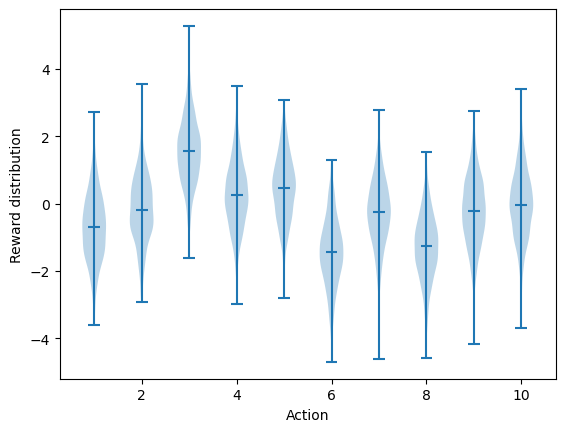

In [2]:
class MultiArmedBanditEnv:
    def __init__(self, k_arms: int = 10, stationary=False):
        self.k_arms = k_arms
        self.stationary = stationary
        self.reset()

    def reset(self):
        self.q_star = np.random.randn(self.k_arms)
        self.best_action = np.argmax(self.q_star)

    def step(self, arm: int):
        if not self.stationary:
            q_drift = np.random.normal(0, 0.1, self.k_arms)
            self.q_star += q_drift
            self.best_action = np.argmax(self.q_star)

        reward: float = np.random.normal() + self.q_star[arm]
        return reward

    def render(self):
        samples = np.random.randn(1000, self.k_arms) + self.q_star
        plt.violinplot(dataset=samples, showmeans=True)
        plt.xlabel("Action")
        plt.ylabel("Reward distribution")
        plt.show()


bandit_env = MultiArmedBanditEnv()
bandit_env.render()


In [3]:
class Gambler:
    def arm(self):
        raise NotImplementedError()

    def update(self, action: int, reward: float):
        raise NotImplementedError()

    def reset(self):
        raise NotImplementedError()


class AveragingGambler(Gambler):
    def __init__(self, total_actions: int = 10, epsilon: float = 0):
        self.total_actions = total_actions
        self.epsilon = epsilon
        self.reset()

    def act(self):
        if np.random.random() < self.epsilon:
            return np.random.choice(self.total_actions)
        return np.argmax(self.Q)

    def update(self, action: int, reward: float):
        self.N[action] += 1
        self.Q[action] += (reward - self.Q[action]) / self.N[action]

    def reset(self):
        self.N = np.zeros(self.total_actions)
        self.Q = np.zeros(self.total_actions)


class FixedLearningStepGambler(Gambler):
    def __init__(self, total_actions: int = 10, epsilon: float = 0, alpha=0.1):
        self.total_actions = total_actions
        self.epsilon = epsilon
        self.alpha = alpha
        self.reset()

    def act(self):
        if np.random.random() < self.epsilon:
            return np.random.choice(self.total_actions)
        return np.argmax(self.Q)

    def update(self, action: int, reward: float):
        self.Q[action] += (reward - self.Q[action]) * self.alpha

    def reset(self):
        self.Q = np.zeros(self.total_actions)


In [4]:
import ray

ray.shutdown()
ray.init()


@ray.remote
def run_episode(
    bandit: MultiArmedBanditEnv, gambler: Gambler, max_time_steps: int = 1e3
):
    rewards = []
    best_action_counts = []
    bandit.reset()
    gambler.reset()
    for _ in range(max_time_steps):
        action = gambler.act()
        reward = bandit.step(action)
        gambler.update(action, reward)
        rewards.append(reward)
        best_action_counts.append(1 if action == bandit.best_action else 0)
    return rewards, best_action_counts


def simulate(
    bandit: MultiArmedBanditEnv,
    gambler: Gambler,
    num_of_episodes: int = 2e3,
    max_time_steps: int = 1e3,
):
    bandit_id = ray.put(bandit)
    gambler_id = ray.put(gambler)
    rewards = np.zeros((num_of_episodes, max_time_steps))
    best_action_counts = np.zeros(rewards.shape)
    episodes = ray.get(
        [
            run_episode.remote(bandit_id, gambler_id, max_time_steps)
            for _ in range(num_of_episodes)
        ]
    )
    for i, (episode_rewards, episode_best_action_counts) in enumerate(episodes):
        rewards[i, :] = episode_rewards
        best_action_counts[i, :] = episode_best_action_counts
    mean_rewards = rewards.mean(axis=0)
    mean_best_action_counts = best_action_counts.mean(axis=0)
    return mean_rewards, mean_best_action_counts


2022-12-02 01:33:17,346	INFO worker.py:1528 -- Started a local Ray instance.


In [9]:
from typing import Type, Optional

def exercise_2_5(bandit: MultiArmedBanditEnv, gambler_cls: Type[Gambler], gambler_args: Optional[dict] = None):
    fig, (mean_reward_plot, mean_best_action_plot) = plt.subplots(1, 2, figsize=(12, 4))
    plot_title = f"{gambler_cls.__name__} - {'Stationary' if bandit.stationary else 'Non-stationary'}" 
    mean_reward_plot.set_title(plot_title)
    mean_reward_plot.set_xlabel("Steps")
    mean_reward_plot.set_ylabel("Avg reward")
    mean_best_action_plot.set_title(plot_title)
    mean_best_action_plot.set_xlabel("Steps")
    mean_best_action_plot.set_ylabel("% Optimal action")
    for epsilon in [0, 0.01, 0.1]:
        mean_rewards, mean_best_action_counts = simulate(
            bandit,
            gambler_cls(epsilon=epsilon, **(gambler_args or {})),
            num_of_episodes=int(2e3),
            max_time_steps=int(5e2),
        )
        mean_reward_plot.plot(mean_rewards, label="$\epsilon = %.02f$" % (epsilon))
        mean_best_action_plot.plot(
            mean_best_action_counts * 100, label="$\epsilon = %.02f$" % (epsilon)
        )
    mean_reward_plot.legend()
    mean_best_action_plot.legend()
    plt.show()

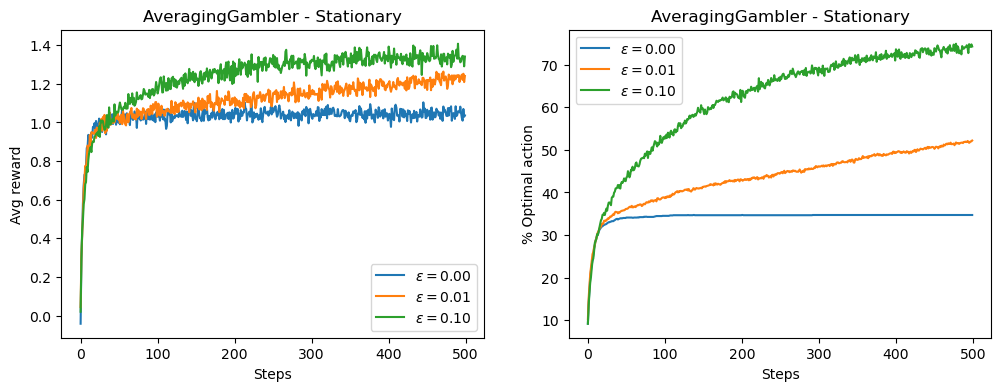

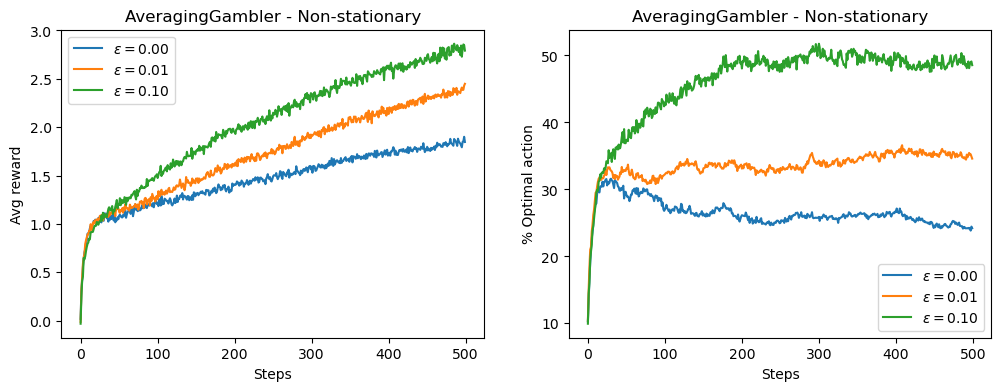

In [10]:
exercise_2_5(MultiArmedBanditEnv(stationary=True), AveragingGambler)
exercise_2_5(MultiArmedBanditEnv(stationary=False), AveragingGambler)

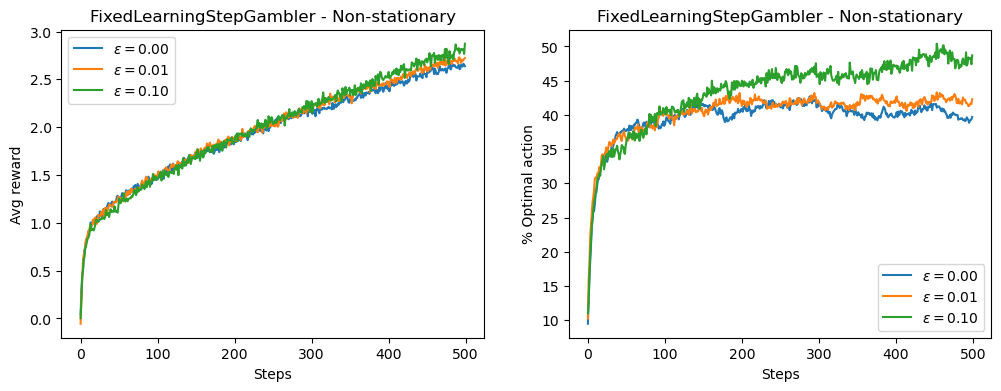

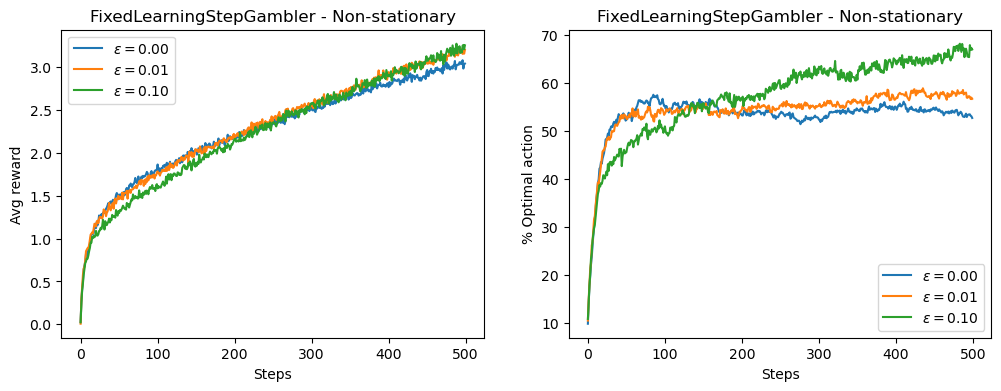

In [11]:
exercise_2_5(
    MultiArmedBanditEnv(stationary=False), FixedLearningStepGambler, {"alpha": 0.1}
)
exercise_2_5(
    MultiArmedBanditEnv(stationary=False), FixedLearningStepGambler, {"alpha": 0.8}
)
